In [1]:
import collections
import functools
import itertools
import json
import pathlib
import pickle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import hier_torch
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
Experiment = collections.namedtuple('Experiment', ['root', 'pattern'])
Trial = collections.namedtuple('Trial', ['root', 'config_file', 'model_file'])

In [122]:
EXP_ROOT = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
PLOT_DIR = 'output/plots/inat21mini-res18-ep20-repeat/'
experiment_defs = {
    'flat_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'flat_softmax-b64-lr0.01-wd0.0003-s*'),
#     'multilabel_focal': Experiment(
#         EXP_ROOT / '2022-03-31-inat21mini-dgx', 'multilabel_focal-0.9-1-lr-0.01-b-64-wd-0.0003-ep-20'),
    'multilabel_focal-1-0.95': Experiment(
        EXP_ROOT / '2022-10-05-inat21mini-errorbar', 'multilabel_focal-1.0-0.95-b64-lr0.01-wd0.0003-s*'),
    'hier_softmax': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'hier_softmax-b64-lr0.01-wd0.0003-s*'),
    'cond_multilabel': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'cond_multilabel-b64-lr0.01-wd0.0003-s*'),
#     'share_random_cut': Experiment(
#         EXP_ROOT / '2022-03-31-inat21mini', 'share_random_cut-0.001-lr-0.01-b-64-wd-0.0003-ep-20'),
#     'share_random_cut': Experiment(
#         EXP_ROOT / '2022-03-31-inat21mini', 'share_random_cut-0-lr-0.01-b-64-wd-0.0003-ep-20'),
    'share_random_cut-0': Experiment(
        EXP_ROOT / '2022-10-05-inat21mini-errorbar', 'share_random_cut-0-b64-lr0.01-wd0.0003-s*'),
    'share_flat_softmax': Experiment(
        EXP_ROOT / '2022-10-05-inat21mini-errorbar', 'share_flat_softmax-b64-lr0.01-wd0.0003-s*'),
#     'share_levelwise': Experiment(
#         EXP_ROOT / '2022-03-31-inat21mini', 'share_levelwise-lr-0.01-b-64-wd-0.0003-ep-20'),
#     'descendant_softmax': Experiment(
#         EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'descendant_softmax-b64-lr0.01-wd0.0003-s*'),
    'descendant_softmax_complement': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'descendant_softmax_complement-b64-lr0.01-wd0.0003-s*'),
    'soft_margin-incorrect-5': Experiment(
        EXP_ROOT / '2022-05-07-inat21mini-errorbar', 'soft_margin-incorrect-5-b64-lr0.01-wd0.0003-s*'),
#     '': Experiment(
#         EXP_ROOT / '', ''),
}

method_titles = {
    'flat_softmax': 'Flat softmax',
    'multilabel_focal-1-0.95': 'Multilabel focal',
    'hier_softmax': 'Cond softmax',
    'cond_multilabel': 'Cond sigmoid',
    'share_random_cut-0': 'Deep RTC',
    'share_flat_softmax': 'PS softmax',
    # 'descendant_softmax': 'Soft-max-descendant (all)',
    'descendant_softmax_complement': 'Soft-max-descendant',
    'soft_margin-incorrect-5': 'Soft-max-margin',
}

In [123]:
colormap = matplotlib.cm.get_cmap('Set1')

# colors = dict(zip(experiments, map(colormap, itertools.count())))

color_index = {
    'flat_softmax': 0,
    'multilabel_focal-1-0.95': 1,
    'hier_softmax': 2,
    'cond_multilabel': 3,
    'share_random_cut-0': 4,
    'share_flat_softmax': 5,
    'descendant_softmax': 6,
    'descendant_softmax_complement': 8,
    'soft_margin-incorrect-5': 7,
}
colors = {k: colormap(v) for k, v in color_index.items()}

In [124]:
trial_names = {
    exp_name: sorted([
        path.name for path in exp_def.root.glob(exp_def.pattern)
        if (path / 'checkpoints/epoch-0020.pth').exists()
    ]) for exp_name, exp_def in experiment_defs.items()
}

trials = {
    exp_name: {
        trial_name: Trial(
            root=experiment_defs[exp_name].root / trial_name,
            config_file=experiment_defs[exp_name].root / trial_name / 'config.json',
            model_file=experiment_defs[exp_name].root / trial_name / 'checkpoints/epoch-0020.pth')
        for trial_name in trial_names[exp_name]
    } for exp_name in trial_names
}

In [125]:
device = torch.device('cuda')

In [126]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, tree, _, _, eval_label_map = main.make_datasets(base_config)

In [127]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

In [128]:
is_root = (np.arange(tree.num_nodes()) == 0)
is_leaf = tree.leaf_mask()
specificity = np.log2(tree.num_leaf_nodes()) - np.log2(tree.num_leaf_descendants())
not_trivial = (tree.num_children() != 1)
subtract_children_cpu = hier_torch.SubtractChildren(tree)
subtract_children_cuda = hier_torch.SubtractChildren(tree).cuda()

In [129]:
@functools.lru_cache(maxsize=None)
def get_matrix_correct_recall():
    gt_nodes = np.arange(tree.num_nodes())[:, None]
    pr_nodes = np.arange(tree.num_nodes())[None, :]

    matrix = (
        metrics.correct(tree, gt_nodes, pr_nodes).astype(np.float32) *
        metrics.LCAMetric(tree, specificity.astype(np.float32)).recall(gt_nodes, pr_nodes)
    )
    matrix = torch.from_numpy(matrix).cuda()
    return matrix

# matrix_info_f1 = (
#     metrics.LCAMetric(tree, specificity.astype(np.float32)).f1(gt_nodes, pr_nodes))
# matrix_correct_info = (
#     metrics.correct(tree, gt_nodes, pr_nodes) * specificity[pr_nodes]
# )

In [130]:
infer_fns = {
    'leaf': lambda p: infer.argmax_where(p, is_leaf),
    # 'exclusive': lambda p: np.argmax(subtract_children_cpu(torch.from_numpy(p)).numpy(), axis=-1),
    'majority': lambda p: infer.argmax_with_confidence(specificity, p, 0.5, not_trivial),
    'plurality': lambda p: infer.argmax_where(
        specificity,
        not_trivial & ((p > infer.plurality_threshold(tree, p, keepdims=True)) | is_root)),
    'expected': lambda p: infer.argmax_where(p * specificity, not_trivial),
#     'crm_correct_recall': lambda p: (
#         infer.argmax_where(
#             torch.tensordot(
#                 subtract_children_cuda(torch.from_numpy(p).cuda()),
#                 get_matrix_correct_recall(),
#                 1,
#             ).cpu().numpy(),
#             not_trivial)),
    # 'crm_info_f1': lambda p: infer.argmax_where(np.dot(p, matrix_info_f1), not_trivial),
    # 'crm_correct_info': lambda p: infer.argmax_where(np.dot(p, matrix_correct_info), not_trivial),
}

markers = {
    'leaf': 'o',
    # 'exclusive': 'x',
    'majority': '^',
    'plurality': '>',
    'expected': 'd',
    'crm_correct_recall': '+',
}

inference_titles = {
    'leaf': 'Leaf',
    # 'exclusive': 'Exclusive',
    'majority': 'Majority',
    'plurality': 'Plurality',
    'expected': 'Expected info',
    'crm_correct_recall': 'Cond risk (correct info)',
}

In [131]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)

metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_excess': info_metric.excess,
    'info_deficient': info_metric.deficient,
    'info_dist': info_metric.dist,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'info_f1': info_metric.f1,
    'depth_excess': depth_metric.excess,
    'depth_deficient': depth_metric.deficient,
    'depth_dist': depth_metric.dist,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
    'depth_f1': depth_metric.f1,
}

metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

In [132]:
def apply_model(net, pred_fn, min_threshold, limit=None, temperature=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {method: [] for method in infer_fns},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': [],
        'prob': [],
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            if temperature:
                theta = theta / temperature
            prob = pred_fn(theta).cpu().numpy()
            pred = {}
            for name, infer_fn in infer_fns.items():
                pred[name] = infer_fn(prob)
            gt_node = eval_label_map.to_node[gt_labels]
            pred_seqs = [
                infer.pareto_optimal_predictions(specificity, p, min_threshold, not_trivial)
                for p in prob
            ]
            prob_seqs = [prob[i, pred_i] for i, pred_i in enumerate(pred_seqs)]
            # Caution: Predictions are *not* truncated.

            outputs['gt'].append(gt_node)
            for method in infer_fns:
                outputs['pred'][method].append(pred[method])
            seq_outputs['pred'].extend(pred_seqs)
            seq_outputs['prob'].extend(prob_seqs)

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [133]:
def assess_predictions(outputs, seq_outputs):
    gt = outputs['gt']
    pred = outputs['pred']
    pred_seq = seq_outputs['pred']
    prob_seq = seq_outputs['prob']

    # Evaluate predictions for each method.
    pred = {
        method: hier.truncate_at_lca(tree, gt, pr)
        for method, pr in pred.items()
    }
    pred_metrics = {
        method: {field: np.mean(metric_fn(gt, pr))
                 for field, metric_fn in metric_fns.items()}
        for method, pr in pred.items()
    }

    # Evaluate predictions in Pareto sequence.
    find_lca = hier.FindLCA(tree)
    specificity_seq = [specificity[pr_i] for pr_i in pred_seq]
    pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
    metric_values_seq = {
        field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
        for field, metric_fn in metric_fns.items()
    }
    pareto_scores, pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
    pareto_means = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [134]:
def update_config(config):  # For backwards compatibility.
    if not hasattr(config.train, 'loss_weighting'):
        setattr(config.train, 'loss_weighting', 'none')
    if not hasattr(config.train, 'margin_tau'):
        setattr(config.train, 'margin_tau', 1.0)
    return config  # For convenience.

def resample_threshold(scores, metric, x):
    return metric[np.searchsorted(-scores, -x)]

In [135]:
# del results

In [136]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [137]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None
IGNORE_CACHE_FILE = False

score_grid = np.flip(np.linspace(0, 1, 1001))

for experiment_name in trials:
    for trial_name, trial in trials[experiment_name].items():
        key = (experiment_name, trial_name)
        if key in results:
            print('cached:', key)
            continue

        results_file = pathlib.Path(trial.root) / f'results-th-{MIN_THRESHOLD}-lim-{LIMIT}.pkl'
        if results_file.exists() and not IGNORE_CACHE_FILE:
            print('load from file:', str(results_file))
            # results[key] = dict(np.load(results_file, allow_pickle=True))
            with open(results_file, 'rb') as f: 
                trial_results = pickle.load(f)
        else:
            print('evaluate:', key)
            # Load model.
            with open(trial.config_file, 'r') as f:
                config = update_config(ml_collections.ConfigDict(json.load(f)))
            num_outputs = main.get_num_outputs(config.predict, tree)
            net = main.make_model(config.model, num_outputs)
            missing_keys, unexpected_keys = net.load_state_dict(torch.load(trial.model_file), strict=True)
            assert not missing_keys
            assert not unexpected_keys

            net.to(device)
            _, pred_fn = main.make_loss(config, tree, device)
            outputs, seq_outputs = apply_model(
                net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT,
                temperature=10.0 if 'share_random_cut' in trial_name else None)
            pred_metrics, pareto_scores, pareto_metrics = assess_predictions(outputs, seq_outputs)
            trial_results = {
                'pred_metrics': pred_metrics,
                'pareto_scores': pareto_scores,
                'pareto_metrics': pareto_metrics,
            }
            # np.savez(results_file, **results[key])
            with open(results_file, 'wb') as f:
                pickle.dump(trial_results, f)

        # Re-sample the Pareto front; also keeps the memory footprint down.
        trial_results.update({
            'pareto_scores': score_grid[1:],
            'pareto_metrics': {
                field: resample_threshold(
                    trial_results['pareto_scores'],
                    trial_results['pareto_metrics'][field],
                    score_grid)
                for field in trial_results['pareto_metrics']
            },
        })
        results[key] = trial_results

cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s0')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s1')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s2')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s3')
cached: ('flat_softmax', 'flat_softmax-b64-lr0.01-wd0.0003-s4')
cached: ('multilabel_focal-1-0.95', 'multilabel_focal-1.0-0.95-b64-lr0.01-wd0.0003-s0')
cached: ('multilabel_focal-1-0.95', 'multilabel_focal-1.0-0.95-b64-lr0.01-wd0.0003-s1')
cached: ('multilabel_focal-1-0.95', 'multilabel_focal-1.0-0.95-b64-lr0.01-wd0.0003-s2')
cached: ('multilabel_focal-1-0.95', 'multilabel_focal-1.0-0.95-b64-lr0.01-wd0.0003-s3')
cached: ('multilabel_focal-1-0.95', 'multilabel_focal-1.0-0.95-b64-lr0.01-wd0.0003-s4')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s0')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s1')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.01-wd0.0003-s2')
cached: ('hier_softmax', 'hier_softmax-b64-lr0.0

In [138]:
# Compute statistics over trials.

pred_metrics = {
    trial_key + (inference_name,): results[trial_key]['pred_metrics'][inference_name]
    for trial_key in results
    for inference_name in infer_fns
}
pred_metrics = pd.DataFrame.from_dict(pred_metrics, orient='index').groupby(level=(0, 2)).describe()
pred_metrics_mean = pred_metrics.stack(0)['mean'].unstack().unstack()
pred_metrics_std = pred_metrics.stack(0)['std'].unstack().unstack()
pred_metrics_mean

correct                                \
                               expected      leaf  majority plurality   
cond_multilabel                0.755414  0.444680  0.808274  0.516450   
descendant_softmax             0.787812  0.517472  0.870208  0.630494   
descendant_softmax_complement  0.782170  0.522875  0.867138  0.631748   
flat_softmax                   0.762656  0.521716  0.849040  0.601988   
hier_softmax                   0.723966  0.443082  0.786326  0.495768   
multilabel_focal               0.509360  0.443872  0.453870  0.521812   
multilabel_focal-1-0.95        0.509360  0.443872  0.453870  0.521812   
share_flat_softmax             0.765894  0.531818  0.816034  0.589878   
share_random_cut               0.531832  0.531832  0.531832  0.322092   
share_random_cut-0             0.531832  0.531832  0.531832  0.322092   
soft_margin-incorrect-5        0.709586  0.530998  0.793542  0.603626   

                              depth_deficient                                \
                                     expected      leaf  majority plurality   
cond_multilabel                      2.494090  1.774510  2.639364  2.155992   
descendant_softmax                   2.398578  1.574582  2.584468  1.839104   
descendant_softmax_complement        2.391145  1.562345  2.522988  1.785093   
flat_softmax                         1.939350  1.572574  2.215638  1.724020   
hier_softmax                         2.386896  1.789674  2.533506  2.072384   
multilabel_focal                     1.915318  1.781590  1.853284  2.290966   
multilabel_focal-1-0.95              1.915318  1.781590  1.853284  2.290966   
share_flat_softmax                   1.872770  1.474454  1.956970  1.591544   
share_random_cut                     1.474450  1.474450  1.474450  2.231910   
share_random_cut-0                   1.474450  1.474450  1.474450  2.231910   
soft_margin-incorrect-5              1.771286  1.584328  1.919120  1.630448   

                              depth_dist            ...   info_f1            \
                                expected      leaf  ...  majority plurality   
cond_multilabel                 3.031672  3.549020  ...  0.567258  0.621819   
descendant_softmax              2.918526  3.149164  ...  0.597179  0.687303   
descendant_softmax_complement   2.927480  3.124690  ...  0.609859  0.694481   
flat_softmax                    2.660774  3.145148  ...  0.636752  0.694626   
hier_softmax                    3.017860  3.579348  ...  0.585439  0.629382   
multilabel_focal                3.263640  3.563180  ...  0.650514  0.607296   
multilabel_focal-1-0.95         3.263640  3.563180  ...  0.650514  0.607296   
share_flat_softmax              2.545694  2.948908  ...  0.679675  0.714085   
share_random_cut                2.948900  2.948900  ...  0.716511  0.568689   
share_random_cut-0              2.948900  2.948900  ...  0.716511  0.568689   
soft_margin-incorrect-5         2.712972  3.168656  ...  0.679159  0.706659   

                              info_precision                                \
                                    expected      leaf  majority plurality   
cond_multilabel                     0.826897  0.655240  0.891669  0.731682   
descendant_softmax                  0.840993  0.697171  0.923905  0.793246   
descendant_softmax_complement       0.836446  0.700079  0.919521  0.791920   
flat_softmax                        0.824203  0.698627  0.916476  0.779029   
hier_softmax                        0.801465  0.652651  0.878799  0.715632   
multilabel_focal                    0.685334  0.653806  0.664531  0.723363   
multilabel_focal-1-0.95             0.685334  0.653806  0.664531  0.723363   
share_flat_softmax                  0.828793  0.716508  0.898076  0.775670   
share_random_cut                    0.716511  0.716511  0.716511  0.568935   
share_random_cut-0                  0.716511  0.716511  0.716511  0.568935   
soft_margin-incorrect-5             0.792337  0.698872  0.882891  0.770584   

           

In [139]:
INTEGRALS = {
    # 'AC(depth)': ('depth_recall', 'correct'),
    'AC(info)': ('info_recall', 'correct'),
    # 'AP(depth)': ('depth_recall', 'depth_precision'),
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(exact)': ('exact', 'correct'),
}

auc = {
    integral_name: {
        trial_key: metrics.pareto_integrate(
            results[trial_key]['pareto_metrics'][x],
            results[trial_key]['pareto_metrics'][y])
        for trial_key in results
    } for integral_name, (x, y) in INTEGRALS.items()
}

# pd.DataFrame(auc).groupby(level=0).describe()
auc_mean = pd.DataFrame(auc).groupby(level=0).mean()
auc_std = pd.DataFrame(auc).groupby(level=0).std()
auc_mean

,AC(info),AP(info),AC(exact)
cond_multilabel,0.571285,0.606399,0.317070
descendant_softmax,0.634787,0.659978,0.399962
descendant_softmax_complement,0.641935,0.664552,0.409051
flat_softmax,0.647121,0.669003,0.446086
hier_softmax,0.574724,0.607170,0.321750
multilabel_focal,0.540794,0.587543,0.276899
multilabel_focal-1-0.95,0.540794,0.587543,0.276899
share_flat_softmax,0.668565,0.689018,0.451494
share_random_cut,0.606744,0.660540,0.458922
share_random_cut-0,0.606744,0.660540,0.458922


In [140]:
INTERCEPTS = [
    'depth_recall',
    'info_recall',
    'exact',
]

CORRECT = [50, 80, 90, 95]

recalls = {
    (y, c): {
        trial_key: metrics.pareto_intercept(
            results[trial_key]['pareto_metrics']['correct'],
            results[trial_key]['pareto_metrics'][y],
            c / 100)
        for trial_key in results
    } for y in INTERCEPTS for c in CORRECT
}

# pd.DataFrame(recalls).groupby(level=0).describe().style.format('{:.3f}'.format)
intercept_mean = pd.DataFrame(recalls).groupby(level=0).mean()
intercept_std = pd.DataFrame(recalls).groupby(level=0).std()
# intercept_mean.columns = intercept_mean.columns.to_flat_index().map(lambda xs: '_'.join(map(str, xs)))
# intercept_std.columns = intercept_std.columns.to_flat_index().map(lambda xs: '_'.join(map(str, xs)))
intercept_mean

depth_recall                                \
                                        50        80        90        95   
cond_multilabel                   0.722087  0.626571  0.567942  0.516585   
descendant_softmax                0.775089  0.681418  0.612367  0.564646   
descendant_softmax_complement     0.776817  0.689901  0.619387  0.571601   
flat_softmax                      0.775389  0.707218  0.652168  0.599911   
hier_softmax                      0.724775  0.632377  0.576912  0.525331   
multilabel_focal                  0.708947  0.576882  0.511661  0.457885   
multilabel_focal-1-0.95           0.708947  0.576882  0.511661  0.457885   
share_flat_softmax                0.789432  0.726750  0.675755  0.625447   
share_random_cut                  0.789364  0.524534  0.319659  0.182748   
share_random_cut-0                0.789364  0.524534  0.319659  0.182748   
soft_margin-incorrect-5           0.773798  0.723443  0.673297  0.621845   

                              info_recall                                \
                                       50        80        90        95   
cond_multilabel                  0.621616  0.481175  0.405228  0.342864   
descendant_softmax               0.697219  0.573031  0.478049  0.418035   
descendant_softmax_complement    0.700090  0.586421  0.491479  0.432883   
flat_softmax                     0.698679  0.597209  0.524407  0.458772   
hier_softmax                     0.626265  0.491812  0.420345  0.357119   
multilabel_focal                 0.604708  0.409338  0.326431  0.268001   
multilabel_focal-1-0.95          0.604708  0.409338  0.326431  0.268001   
share_flat_softmax               0.716577  0.622873  0.555525  0.491349   
share_random_cut                 0.716511  0.492951  0.305618  0.176379   
share_random_cut-0               0.716511  0.492951  0.305618  0.176379   
soft_margin-incorrect-5          0.699036  0.626081  0.565325  0.506455   

                                  exact                                
                                     50        80        90        95  
cond_multilabel                0.374768  0.161610  0.081642  0.036892  
descendant_softmax             0.517472  0.248640  0.115474  0.069962  
descendant_softmax_complement  0.522875  0.264820  0.120210  0.075513  
flat_softmax                   0.521716  0.356894  0.273488  0.206410  
hier_softmax                   0.382210  0.175084  0.098928  0.049620  
multilabel_focal               0.324328  0.068690  0.023430  0.007812  
multilabel_focal-1-0.95        0.324328  0.068690  0.023430  0.007812  
share_flat_softmax             0.531818  0.355362  0.263804  0.188844  
share_random_cut               0.531832  0.393658  0.251264  0.147122  
share_random_cut-0             0.531832  0.393658  0.251264  0.147122  
soft_margin-incorrect-5        0.530998  0.426290  0.364252  0.309544

In [141]:
# Main table for paper!

tables = {
    'pred_mean': pred_metrics_mean,
    'pred_std': pred_metrics_std,
    'auc_mean': auc_mean,
    'auc_std': auc_std,
    'intercept_mean': intercept_mean,
    'intercept_std': intercept_std,
}

cols = [
    ('auc', 'AP(info)'),
    ('auc', 'AC(info)'),
    # ('intercept', ('info_recall', 50)),
    # ('intercept', ('info_recall', 80)),
    ('intercept', ('info_recall', 90)),
    ('intercept', ('info_recall', 95)),
    # ('intercept', ('exact', 90)),
    # ('intercept', ('exact', 95)),
    # ('pred', ('correct', 'leaf')),
    # ('pred', ('info_recall', 'leaf')),
    # ('pred', ('correct', 'majority')),
    # ('pred', ('info_recall', 'majority')),
    ('pred', ('info_f1', 'majority')),
    ('pred', ('info_f1', 'leaf')),
]

table = pd.DataFrame(dict(itertools.chain.from_iterable(
    [((table, col, 'mean'), tables[table + '_mean'][col]),
     ((table, col, 'err'), 1.96 * tables[table + '_std'][col])]
    for table, col in cols
)))
table = table.loc[list(experiment_defs)]
table = table.set_index(table.index.map(method_titles))

def format_column(data, format_fn, highlight=None):
    formatted = data.apply(format_fn)
    if highlight:
        rank = data.rank(ascending=False)
        is_max = (rank < 2)
        is_second = (2 <= rank) & (rank < 3)
        bolded = formatted.apply(lambda x: r'{\bf %s}' % x)
        italicized = formatted.apply(lambda x: r'{\it %s}' % x)
        formatted = italicized.where(is_second, formatted)
        formatted = bolded.where(is_max, formatted)
    return formatted

table = pd.DataFrame({
    c: format_column(
        table[c],
        lambda x: ((r'$\pm$' if 'err' in c else '') + f'{x * 100:.2f}') if x == x else '',
        highlight='max' if 'mean' in c else None)
    for c in table.columns
})
table

# bold_extreme_values(table, )
# table.style.format(lambda x: f'{x * 100:.2f}')

auc                                     \
                        AP(info)                AC(info)              
                            mean        err         mean        err   
Flat softmax               66.90  $\pm$0.16        64.71  $\pm$0.18   
Multilabel focal           58.75  $\pm$0.24        54.08  $\pm$0.20   
Cond softmax               60.72  $\pm$0.11        57.47  $\pm$0.13   
Cond sigmoid               60.64  $\pm$0.17        57.13  $\pm$0.16   
Deep RTC                   66.05  $\pm$0.16        60.67  $\pm$0.15   
PS softmax           {\bf 68.90}  $\pm$0.13  {\bf 66.86}  $\pm$0.12   
Soft-max-descendant        66.46  $\pm$0.37        64.19  $\pm$0.39   
Soft-max-margin      {\it 67.63}  $\pm$0.25  {\it 65.97}  $\pm$0.26   

                            intercept                                          \
                    (info_recall, 90)            (info_recall, 95)              
                                 mean        err              mean        err   
Flat softmax                    52.44  $\pm$0.42             45.88  $\pm$0.30   
Multilabel focal                32.64  $\pm$0.16             26.80  $\pm$0.28   
Cond softmax                    42.03  $\pm$0.12             35.71  $\pm$0.20   
Cond sigmoid                    40.52  $\pm$0.13             34.29  $\pm$0.18   
Deep RTC                        30.56  $\pm$0.79             17.64  $\pm$1.01   
PS softmax                {\it 55.55}  $\pm$0.22       {\it 49.13}  $\pm$0.15   
Soft-max-descendant             49.15  $\pm$0.36             43.29  $\pm$0.56   
Soft-max-margin           {\bf 56.53}  $\pm$0.28       {\bf 50.65}  $\pm$0.41   

                                   pred                                        
                    (info_f1, majority)            (info_f1, leaf)             
                                   mean        err            mean        err  
Flat softmax                      63.68  $\pm$0.19           69.86  $\pm$0.13  
Multilabel focal                  65.05  $\pm$0.24           65.38  $\pm$0.29  
Cond softmax                      58.54  $\pm$0.20           65.27  $\pm$0.11  
Cond sigmoid                      56.73  $\pm$0.07           65.52  $\pm$0.19  
Deep RTC                    {\bf 71.65}  $\pm$0.12     {\bf 71.65}  $\pm$0.12  
PS softmax                  {\it 67.97}  $\pm$0.19     {\it 71.65}  $\pm$0.12  
Soft-max-descendant               60.99  $\pm$0.33           70.01  $\pm$0.33  
Soft-max-margin                   67.92  $\pm$0.27           69.89  $\pm$0.24

In [142]:
print(table.to_latex(escape=False))

\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{4}{l}{auc} & \multicolumn{4}{l}{intercept} & \multicolumn{4}{l}{pred} \\
{} & \multicolumn{2}{l}{AP(info)} & \multicolumn{2}{l}{AC(info)} & \multicolumn{2}{l}{(info_recall, 90)} & \multicolumn{2}{l}{(info_recall, 95)} & \multicolumn{2}{l}{(info_f1, majority)} & \multicolumn{2}{l}{(info_f1, leaf)} \\
{} &         mean &        err &         mean &        err &              mean &        err &              mean &        err &                mean &        err &            mean &        err \\
\midrule
Flat softmax        &        66.90 &  $\pm$0.16 &        64.71 &  $\pm$0.18 &             52.44 &  $\pm$0.42 &             45.88 &  $\pm$0.30 &               63.68 &  $\pm$0.19 &           69.86 &  $\pm$0.13 \\
Multilabel focal    &        58.75 &  $\pm$0.24 &        54.08 &  $\pm$0.20 &             32.64 &  $\pm$0.16 &             26.80 &  $\pm$0.28 &               65.05 &  $\pm$0.24 &           65.38 &  $\pm$0.29 \\
Cond softmax    

/tmp/ipykernel_1575951/1166261648.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(escape=False))


In [143]:
# x = np.linspace(0, 1, 1001)
# stacked_resampled = {
#     field: np.stack([
#         resample_threshold(results[k]['pareto_scores'], results[k]['pareto_metrics'][field], x)
#         for k in results
#     ], axis=0) for field in metric_fns
# }

In [144]:
stacked_resampled = {
    (trial_key + (field,)): results[trial_key]['pareto_metrics'][field]
    for trial_key in results
    for field in metric_fns
}
resampled_mean = pd.DataFrame.from_dict(stacked_resampled).T.groupby(level=(0, 2)).mean().T
resampled_std = pd.DataFrame.from_dict(stacked_resampled).T.groupby(level=(0, 2)).std().T
resampled_mean

cond_multilabel                                                    \
             correct depth_deficient depth_dist depth_excess  depth_f1   
0           1.000000        6.955908   6.955908     0.000000  0.009810   
1           0.999540        5.522318   5.523236     0.000918  0.290994   
2           0.999212        5.251990   5.253532     0.001542  0.341903   
3           0.998852        5.086392   5.088572     0.002180  0.372654   
4           0.998538        4.967818   4.970546     0.002728  0.394431   
...              ...             ...        ...          ...       ...   
996         0.444678        1.774536   3.548962     1.774426  0.746497   
997         0.444680        1.774510   3.548994     1.774484  0.746499   
998         0.444680        1.774510   3.549014     1.774504  0.746499   
999         0.444680        1.774510   3.549020     1.774510  0.746499   
1000        0.444680        1.774510   3.549020     1.774510  0.746499   

                                                                       ...  \
     depth_precision depth_recall     exact info_deficient  info_dist  ...   
0           1.000000     0.006299  0.000000      13.245005  13.245005  ...   
1           0.999632     0.211097  0.000000      11.831909  11.832911  ...   
2           0.999408     0.249716  0.000024      11.554455  11.556142  ...   
3           0.999158     0.273373  0.000036      11.379167  11.381584  ...   
4           0.998954     0.290312  0.000060      11.249799  11.252860  ...   
...              ...          ...       ...            ...        ...  ...   
996         0.746501     0.746495  0.444678       4.581137   9.162138  ...   
997         0.746500     0.746499  0.444680       4.581072   9.162110  ...   
998         0.746499     0.746499  0.444680       4.581072   9.162134  ...   
999         0.746499     0.746499  0.444680       4.581072   9.162145  ...   
1000        0.746499     0.746499  0.444680       4.581072   9.162145  ...   

     soft_margin-incorrect-5                                         \
                    depth_f1 depth_precision depth_recall     exact   
0                   0.104100        0.999854     0.080823  0.000754   
1                   0.316373        0.999372     0.254036  0.078592   
2                   0.365832        0.999085     0.295881  0.094508   
3                   0.396283        0.998822     0.322085  0.105842   
4                   0.418375        0.998602     0.341385  0.114854   
...                      ...             ...          ...       ...   
996                 0.773669        0.773670     0.773669  0.530998   
997                 0.773668        0.773668     0.773667  0.530998   
998                 0.773667        0.773667     0.773667  0.530998   
999                 0.773667        0.773667     0.773667  0.530998   
1000                0.773667        0.773667     0.773667  0.530998   

                                                                     \
     info_deficient  info_dist info_excess   info_f1 info_precision   
0         12.615665  12.616302    0.000637  0.068672       0.999848   
1         11.017108  11.020329    0.003220  0.216578       0.999352   
2         10.586773  10.591924    0.005151  0.255274       0.999047   
3         10.309723  10.316658    0.006935  0.279709       0.998763   
4         10.100629  10.109429    0.008799  0.297866       0.998517   
...             ...        ...         ...       ...            ...   
996        4.001281   8.002539    4.001258  0.698874       0.698874   
997        4.001302   8.002599    4.001297  0.698872       0.698872   
998        4.001302   8.002604    4.001302  0.698872       0.698872   
999        4.001302   8.002604    4.001302  0.698872       0.698872   
1000       4.001302   8.002604    4.001302  0.698872       0.698872   

                  
     info_recall  
0       0.050577  
1       0.170880  
2       0.203266  
3       0.224116  
4       0.239852  
...          ...  
996     0.698874  
997     

In [145]:
def plot_pareto_with_std(x_mean, y_mean, x_std, y_std, num_std=1.96, x_grid=None, **kwargs):
    lower_x = x_mean - num_std * x_std
    lower_y = y_mean - num_std * y_std
    upper_x = x_mean + num_std * x_std
    upper_y = y_mean + num_std * y_std
    if x_grid is None:
        plt.fill(
            np.concatenate((lower_x, np.flip(upper_x))),
            np.concatenate((lower_y, np.flip(upper_y))), **kwargs)
    else:
        # Sample lower and upper bounds at grid.
        lower = metrics.pareto_intercept(lower_x, lower_y, x_grid)
        upper = metrics.pareto_intercept(upper_x, upper_y, x_grid)
        plt.fill_between(x_grid, lower, upper, **kwargs)

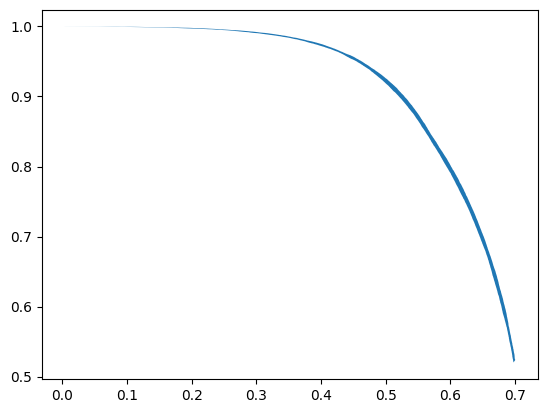

In [146]:
# Example usage.

plot_pareto_with_std(
    x_mean=resampled_mean['flat_softmax']['info_recall'],
    x_std=resampled_std['flat_softmax']['info_recall'],
    y_mean=resampled_mean['flat_softmax']['correct'],
    y_std=resampled_std['flat_softmax']['correct'],
    num_std=1.96,
    # x_grid=np.linspace(0, 1, 101),
)

In [153]:
def plot_metrics(x, y, tickres=None, save=False, xlim=None, ylim=None, figsize=(5, 4)):
    line_handles = []
    point_handles = []
    first_line = True
    plt.figure(figsize=figsize)

    for method_name in trials:
        method_trials = [
            trial_name for trial_name in trials[method_name]
            if (method_name, trial_name) in results
        ]
        # print('num trials:', len(method_trials))
        if not trial_names:
            continue

        # Plot errorbars.
        plot_pareto_with_std(
            x_mean=resampled_mean[method_name][x],
            y_mean=resampled_mean[method_name][y],
            x_std=resampled_std[method_name][x],
            y_std=resampled_std[method_name][y],
            color=colors[method_name],
            alpha=0.333)

        ge = (score_grid >= 0.5)
        le = (score_grid <= 0.5)
        plt.plot(
            resampled_mean[method_name][x][le], resampled_mean[method_name][y][le],
            color=colors[method_name], linestyle='--')
        h = plt.plot(
            resampled_mean[method_name][x][ge], resampled_mean[method_name][y][ge],
            color=colors[method_name], label=method_titles.get(method_name, method_name))
        line_handles.extend(h)

        for inference_name in infer_fns:  # pred_metrics_mean[x][method_name].keys():
            h, = plt.plot(
                pred_metrics_mean[x][inference_name][method_name],
                pred_metrics_mean[y][inference_name][method_name],
                color=colors[method_name], linestyle='none',
                marker=markers[inference_name], markerfacecolor='none',
                label=inference_titles.get(inference_name, inference_name))
            if first_line:
                point_handles.append(h)
        first_line = False

    plt.grid('on')
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))
    ax = plt.gca()

    if xlim:
        plt.xlim(**xlim)
    if ylim:
        plt.ylim(**ylim)
    # plt.ylim(np.clip(plt.ylim(), 0, 1))
    # plt.xlim(np.clip(plt.xlim(), 0, 1))
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    # plt.axis('equal')
    # plt.gca().set_aspect(1)

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}.pdf')
        main_fig = plt.gcf()
        plt.figure(figsize=figsize)
        plt.legend(handles=[*line_handles, *point_handles], loc='center left')
        plt.axis('off')
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{x}-{y}-legend.pdf')
        plt.close()
        plt.figure(main_fig.number)

    plt.legend(handles=[*line_handles, *point_handles], loc='lower left')
    plt.show()

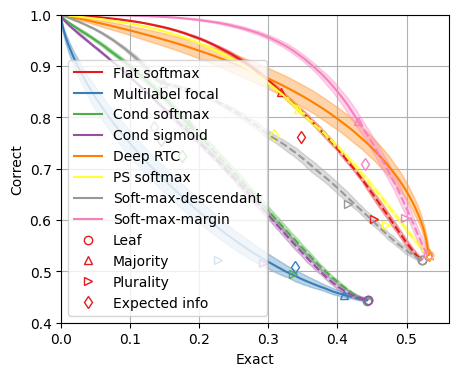

In [154]:
plot_metrics('exact', 'correct', tickres=0.1, xlim=dict(left=0), ylim=dict(top=1, bottom=0.4), save=True)

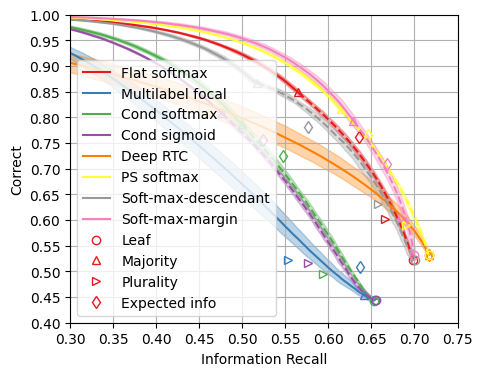

In [155]:
plot_metrics('info_recall', 'correct', tickres=0.05, xlim=dict(left=0.3, right=0.75), ylim=dict(bottom=0.4, top=1), save=True)

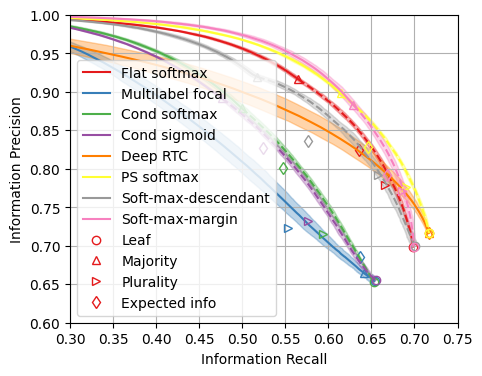

In [156]:
plot_metrics('info_recall', 'info_precision', tickres=0.05, xlim=dict(left=0.3, right=0.75), ylim=dict(bottom=0.6, top=1), save=True)

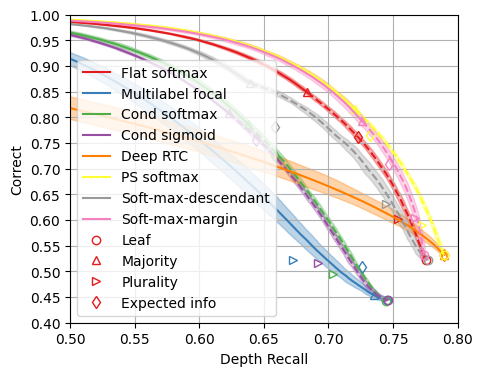

In [157]:
plot_metrics('depth_recall', 'correct', tickres=0.05, xlim=dict(left=0.5, right=0.8), ylim=dict(bottom=0.4, top=1), save=True)

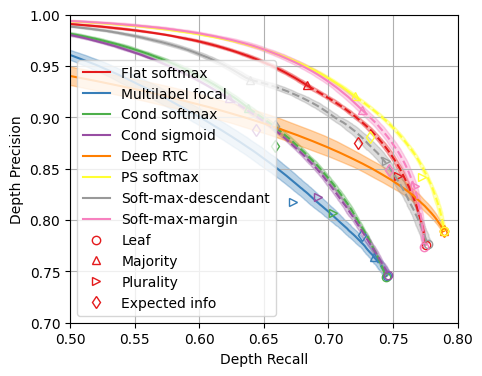

In [158]:
plot_metrics('depth_recall', 'depth_precision', tickres=0.05, xlim=dict(left=0.5, right=0.8), ylim=dict(bottom=0.7, top=1), save=True)